# Advanced CTGAN Training and Evaluation

This section enhances the basic CTGAN training with:
1. Improved data preprocessing with outlier handling
2. Enhanced CTGAN training with better hyperparameters
3. Comprehensive synthetic data evaluation
4. Feature importance analysis
5. PCA visualization for distribution comparison
6. Cross-validation evaluation

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import time
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
from ctgan import CTGAN

import matplotlib.pyplot as plt
# Set the random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Load the PDF features dataset
file_path = '/home/nhat/projectcuoiky/data/pdf_features.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nFeature columns: {list(df.columns)}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nColumns with missing values:\n{missing_values[missing_values > 0]}")

# Encode the label column if needed
if 'label' in df.columns and 'label_numeric' not in df.columns:
    le = LabelEncoder()
    df['label_numeric'] = le.fit_transform(df['label'])
    print(f"\nLabel encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Drop features that might not be relevant for analysis (based on cell 6)
features_to_drop = ['filepath', 'filename', '_Colors_gt_224', 'endobj', 'endstream']
for col in features_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Summary of the dataset
print(f"\nClass distribution:")
print(df['label_numeric'].value_counts())

# Display some sample data
print("\nSample of the dataset:")
print(df.head())

Dataset shape: (11101, 25)

Feature columns: ['Page', 'Encrypt', 'ObjStm', 'JS', 'JavaScript', 'AA', 'OpenAction', 'AcroForm', 'JBIG2Decode', 'RichMedia', 'Launch', 'EmbeddedFile', 'XFA', 'Colors_gt_224', 'obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref', 'filepath', 'filename', 'filesize_kb', 'label']

Columns with missing values:
Series([], dtype: int64)

Label encoding: {'benign': 0, 'malicious': 1}

Class distribution:
label_numeric
0    9107
1    1994
Name: count, dtype: int64

Sample of the dataset:
   Page  Encrypt  ObjStm  JS  JavaScript  AA  OpenAction  AcroForm  \
0     1        0       0   0           0   0           0         0   
1     1        0       0   0           0   0           0         0   
2     4        0       6   0           0   0           0         0   
3     1        0       0   0           0   0           0         1   
4     6        0      25   0           0   0           0         2   

   JBIG2Decode  RichMedia  ...  XFA  Colors_gt_

In [29]:
# === 1. Improved Data Preprocessing ===

def preprocess_for_ctgan(df_features_only, log_columns=None):
    """
    Preprocess feature data for CTGAN training with improved scaling and outlier handling.
    Input df_features_only should NOT contain label columns.
    """
    df_processed = df_features_only.copy()
    
    # 1. Log transformation for highly skewed columns
    if log_columns:
        for col in log_columns:
            if col in df_processed.columns and pd.api.types.is_numeric_dtype(df_processed[col]):
                # Ensure no negative or zero values before log if log1p is not sufficient
                if (df_processed[col] <= 0).any():
                    print(f"Warning: Column {col} contains non-positive values. Applying log1p after clipping to 0.")
                    df_processed[col] = np.log1p(df_processed[col].clip(lower=0))
                else:
                    df_processed[col] = np.log1p(df_processed[col])
    
    # 2. Detect and handle outliers on all numeric columns present
    current_numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in current_numeric_cols:
        # Skip if column is empty or all NaN
        if df_processed[col].isnull().all() or df_processed[col].empty:
            continue
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        # Avoid issues if IQR is 0 (e.g., mostly constant column)
        if IQR > 0:
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)
    
    # 3. Identify constant and near-constant columns from the *current* numeric columns
    # These will be dropped BEFORE scaling.
    constant_cols_to_drop = [col for col in current_numeric_cols if df_processed[col].nunique(dropna=False) <= 1]
    
    near_constant_cols_to_drop = []
    for col in current_numeric_cols:
        if col not in constant_cols_to_drop and not df_processed[col].empty:
            if df_processed[col].nunique(dropna=False) == 1:
                 if col not in constant_cols_to_drop: near_constant_cols_to_drop.append(col) # Technically constant
            elif df_processed[col].nunique(dropna=False) > 1 :
                most_frequent_count = df_processed[col].value_counts(dropna=False).iloc[0]
                if (most_frequent_count / len(df_processed[col])) >= 0.99: # 99% threshold
                     near_constant_cols_to_drop.append(col)
        elif df_processed[col].empty and col not in constant_cols_to_drop:
             constant_cols_to_drop.append(col)
             
    constant_columns_original_values = {
        col: df_features_only[col].iloc[0] if not df_features_only[col].empty else np.nan
        for col in constant_cols_to_drop 
        if col in df_features_only.columns
    }
    near_constant_columns_original_values = {
        col: df_features_only[col].mode()[0] if not df_features_only[col].empty and not df_features_only[col].mode().empty else np.nan
        for col in near_constant_cols_to_drop
        if col in df_features_only.columns
    }
    
    cols_to_drop_before_scaling = list(set(constant_cols_to_drop + near_constant_cols_to_drop))
    if cols_to_drop_before_scaling:
        print(f"Dropping constant/near-constant columns before scaling: {cols_to_drop_before_scaling}")
        df_processed.drop(columns=cols_to_drop_before_scaling, inplace=True, errors='ignore')
        
    # 4. Feature scaling on remaining numeric columns
    scaler = StandardScaler()
    numeric_cols_for_scaling = df_processed.select_dtypes(include=[np.number]).columns.tolist()

    fitted_scaler_feature_names = []
    if numeric_cols_for_scaling:
        df_processed[numeric_cols_for_scaling] = scaler.fit_transform(df_processed[numeric_cols_for_scaling])
        if hasattr(scaler, 'feature_names_in_'):
             fitted_scaler_feature_names = scaler.feature_names_in_.tolist()
        elif hasattr(scaler, 'n_features_in_') and scaler.n_features_in_ > 0 :
             fitted_scaler_feature_names = numeric_cols_for_scaling
    
    metadata = {
        'scaler': scaler,
        'fitted_scaler_feature_names': fitted_scaler_feature_names,
        'constant_columns_original_values': constant_columns_original_values,
        'near_constant_columns_original_values': near_constant_columns_original_values,
        'log_columns': log_columns or [],
        'final_feature_columns_for_ctgan': df_processed.columns.tolist()
    }
    
    return df_processed, metadata

# === 2. Enhanced CTGAN Training ===

def train_ctgan_with_monitoring(df_features_for_ctgan, discrete_columns_for_ctgan, epochs=300, batch_size=500):
    """
    Train CTGAN with more hyperparameter options and better monitoring.
    df_features_for_ctgan: DataFrame containing only the features (already processed) for CTGAN.
    discrete_columns_for_ctgan: List of column names in df_features_for_ctgan to be treated as discrete.
    """
    ctgan_model = CTGAN( # Renamed from ctgan to avoid conflict if this cell is run multiple times
        epochs=epochs,
        batch_size=batch_size,
        discriminator_steps=1,
        log_frequency=True,
        verbose=True,
        embedding_dim=128,
        generator_dim=(256, 512, 256),
        discriminator_dim=(512, 256),
        pac=4
    )
    
    start_time = time.time()
    print(f"Starting CTGAN training with {epochs} epochs at {time.strftime('%H:%M:%S')}")
    
    valid_discrete_columns = [col for col in discrete_columns_for_ctgan if col in df_features_for_ctgan.columns]
    if len(valid_discrete_columns) != len(discrete_columns_for_ctgan):
        print(f"Warning: Some discrete columns were not found in the data for CTGAN: {set(discrete_columns_for_ctgan) - set(valid_discrete_columns)}")

    ctgan_model.fit(df_features_for_ctgan, discrete_columns=valid_discrete_columns)
    
    elapsed = time.time() - start_time
    print(f"CTGAN training completed in {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
    
    return ctgan_model

In [30]:
def generate_and_evaluate_synthetic_data(ctgan_model, original_features_unprocessed, metadata, n_samples, seed=None):
    """
    Generate synthetic data and evaluate it with multiple metrics.
    
    Args:
        ctgan_model: The trained CTGAN model.
        original_features_unprocessed: DataFrame of real malicious features in their original scale.
        metadata: Dictionary from preprocess_for_ctgan.
        n_samples: Number of synthetic samples to generate.
        seed: Optional random seed for reproducibility.
        
    Returns:
        dict: Contains synthetic data and evaluation metrics.
    """
    def get_clip_ranges(real_data, quantile_range=(0.01, 0.99)):
        """Calculate clip ranges based on quantiles of real data."""
        clip_ranges = {}
        for col in ['filesize_kb', 'Page', 'obj', 'stream']:
            if col in real_data.columns and pd.api.types.is_numeric_dtype(real_data[col]):
                try:
                    low = real_data[col].quantile(quantile_range[0])
                    high = real_data[col].quantile(quantile_range[1])
                    
                    # Ensure valid range
                    if pd.isna(low) or pd.isna(high) or high <= low:
                        print(f"Warning: Invalid clip range for {col}: ({low}, {high}). Using min/max.")
                        low, high = real_data[col].min(), real_data[col].max()
                    
                    # Add buffer to avoid edge cases
                    buffer = max(1, (high - low) * 0.1)  # 10% buffer
                    clip_ranges[col] = (max(0, low - buffer), high + buffer)
                    
                except Exception as e:
                    print(f"Error calculating clip range for {col}: {str(e)}")
                    if col in real_data.columns:
                        clip_ranges[col] = (real_data[col].min(), real_data[col].max())
        return clip_ranges

    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    print(f"Generating {n_samples} synthetic samples...")
    try:
        synthetic_processed_features = ctgan_model.sample(n_samples)
    except Exception as e:
        print(f"Error generating samples: {str(e)}")
        return None

    # Initialize output dataframe
    synthetic_reconstructed_df = synthetic_processed_features.copy()

    # Inverse transform scaled features
    if (cols_that_were_scaled := metadata.get('fitted_scaler_feature_names', [])) and \
       hasattr(metadata.get('scaler'), 'transform'):
        try:
            cols_to_inverse = [col for col in cols_that_were_scaled if col in synthetic_reconstructed_df.columns]
            if cols_to_inverse:
                synthetic_reconstructed_df[cols_to_inverse] = metadata['scaler'].inverse_transform(
                    synthetic_reconstructed_df[cols_to_inverse]
                )
        except Exception as e:
            print(f"Error in inverse transform: {str(e)}")

    # Handle constant and near-constant columns
    for col_dict in ['constant_columns_original_values', 'near_constant_columns_original_values']:
        for col, val in metadata.get(col_dict, {}).items():
            if col in original_features_unprocessed.columns:
                if isinstance(val, (int, float, str, bool)):
                    synthetic_reconstructed_df[col] = val
                elif isinstance(val, (pd.Series, np.ndarray)) and len(val) > 0:
                    synthetic_reconstructed_df[col] = val[0]
                else:
                    synthetic_reconstructed_df[col] = original_features_unprocessed[col].mode()[0] \
                        if not original_features_unprocessed[col].empty else 0

    # Apply exponential transform to log-scaled columns
    for col in metadata.get('log_columns', []):
        if col in synthetic_reconstructed_df.columns and pd.api.types.is_numeric_dtype(synthetic_reconstructed_df[col]):
            synthetic_reconstructed_df[col] = np.expm1(synthetic_reconstructed_df[col])

    # Ensure all original columns are present
    synthetic_reconstructed_df = synthetic_reconstructed_df.reindex(columns=original_features_unprocessed.columns)

    # Handle missing values
    for col in synthetic_reconstructed_df.columns:
        if pd.api.types.is_numeric_dtype(synthetic_reconstructed_df[col]):
            if synthetic_reconstructed_df[col].isnull().any():
                fill_val = original_features_unprocessed[col].median() if col in original_features_unprocessed else 0
                synthetic_reconstructed_df[col] = synthetic_reconstructed_df[col].fillna(fill_val)

    # Ensure non-negative values where appropriate
    for col in synthetic_reconstructed_df.columns:
        if (col in original_features_unprocessed.columns and 
            pd.api.types.is_numeric_dtype(original_features_unprocessed[col]) and
            (original_features_unprocessed[col] >= 0).all()):
            synthetic_reconstructed_df[col] = synthetic_reconstructed_df[col].clip(lower=0)

    # Handle integer columns
    original_integer_cols = [
        col for col in original_features_unprocessed.columns
        if pd.api.types.is_integer_dtype(original_features_unprocessed[col])
    ]
    for col in original_integer_cols:
        if col in synthetic_reconstructed_df.columns:
            synthetic_reconstructed_df[col] = synthetic_reconstructed_df[col].round().fillna(0).astype(np.int64)

    # Process specific binary columns
    binary_cols = ['JS', 'JavaScript', 'AA', 'OpenAction', 'AcroForm', 
                  'EmbeddedFile', 'XFA', 'Encrypt', 'RichMedia', 'Launch']
    for col in binary_cols:
        if col in synthetic_reconstructed_df.columns:
            synthetic_reconstructed_df[col] = pd.to_numeric(
                synthetic_reconstructed_df[col], errors='coerce'
            ).fillna(0).clip(0, 1).round().astype(np.int8)

    # Special handling for ObjStm
    if 'ObjStm' in synthetic_reconstructed_df.columns:
        synthetic_reconstructed_df['ObjStm'] = (
            pd.to_numeric(synthetic_reconstructed_df['ObjStm'], errors='coerce')
            .fillna(0)
            .clip(0, 6)
            .round()
            .astype(np.int8)
        )

    # Apply business rules
    if all(col in synthetic_reconstructed_df.columns for col in ['JavaScript', 'OpenAction']):
        synthetic_reconstructed_df['OpenAction'] = np.maximum(
            synthetic_reconstructed_df['JavaScript'], 
            synthetic_reconstructed_df['OpenAction']
        )

    # Handle embedded files and filesize relationship
    if all(col in synthetic_reconstructed_df.columns for col in ['EmbeddedFile', 'filesize_kb']):
        embedded_mask = synthetic_reconstructed_df['EmbeddedFile'] > 0.5
        if embedded_mask.any():
            real_embedded = original_features_unprocessed[
                original_features_unprocessed['EmbeddedFile'] > 0.5
            ]
            if not real_embedded.empty and 'filesize_kb' in real_embedded.columns:
                size_increases = np.random.choice(
                    real_embedded['filesize_kb'].dropna(),
                    size=embedded_mask.sum(),
                    replace=True
                )
                synthetic_reconstructed_df.loc[embedded_mask, 'filesize_kb'] = np.maximum(
                    synthetic_reconstructed_df.loc[embedded_mask, 'filesize_kb'],
                    size_increases
                )

    # Apply clipping based on real data distributions
    clip_ranges = get_clip_ranges(original_features_unprocessed)
    for col, (low, high) in clip_ranges.items():
        if col in synthetic_reconstructed_df.columns:
            synthetic_reconstructed_df[col] = synthetic_reconstructed_df[col].clip(low, high)
            if col in original_integer_cols:
                synthetic_reconstructed_df[col] = synthetic_reconstructed_df[col].round().astype(np.int64)

    # Add labels
    synthetic_reconstructed_df['label_numeric'] = 1
    synthetic_reconstructed_df['label'] = 'malicious'

    # Calculate Frobenius norm of correlation matrix difference
    fro_norm = np.nan
    numeric_cols = [
        col for col in original_features_unprocessed.columns
        if (col in synthetic_reconstructed_df.columns and
            pd.api.types.is_numeric_dtype(original_features_unprocessed[col]) and
            pd.api.types.is_numeric_dtype(synthetic_reconstructed_df[col]))
    ]
    
    if numeric_cols:
        try:
            real_corr = original_features_unprocessed[numeric_cols].corr().fillna(0)
            synth_corr = synthetic_reconstructed_df[numeric_cols].corr().fillna(0)
            fro_norm = np.linalg.norm(real_corr - synth_corr)
        except Exception as e:
            print(f"Error calculating Frobenius norm: {str(e)}")

    # Perform KS tests
    ks_results = {}
    features_for_ks = numeric_cols[:min(20, len(numeric_cols))]  # Limit to top 20 features
    for col in features_for_ks:
        try:
            real_data = original_features_unprocessed[col].dropna()
            synth_data = synthetic_reconstructed_df[col].dropna()
            if len(real_data) > 1 and len(synth_data) > 1:
                statistic, pvalue = ks_2samp(real_data, synth_data)
                ks_results[col] = {'statistic': statistic, 'pvalue': pvalue}
        except Exception as e:
            ks_results[col] = {'statistic': np.nan, 'pvalue': np.nan, 'error': str(e)}

    # Generate visualization
    fig = None
    top_features = numeric_cols[:min(5, len(numeric_cols))]
    if top_features:
        n_cols = 2
        n_rows = len(top_features)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)  # Ensure 2D array even for single row
            
        for i, feature in enumerate(top_features):
            # Distribution plot
            ax_hist = axes[i, 0]
            sns.histplot(
                original_features_unprocessed[feature].dropna(),
                ax=ax_hist, color='blue', alpha=0.5, label='Real', kde=True
            )
            sns.histplot(
                synthetic_reconstructed_df[feature].dropna(),
                ax=ax_hist, color='red', alpha=0.5, label='Synthetic', kde=True
            )
            ax_hist.set_title(f'Distribution of {feature}')
            ax_hist.legend()

            # Q-Q plot
            ax_qq = axes[i, 1]
            real_sample = original_features_unprocessed[feature].dropna().sample(
                min(1000, len(original_features_unprocessed[feature].dropna())),
                random_state=seed
            )
            synth_sample = synthetic_reconstructed_df[feature].dropna().sample(
                min(1000, len(synthetic_reconstructed_df[feature].dropna())),
                random_state=seed
            )
            
            if len(real_sample) > 1 and len(synth_sample) > 1:
                q_real = np.percentile(real_sample, range(0, 101))
                q_synth = np.percentile(synth_sample, range(0, 101))
                ax_qq.scatter(q_real, q_synth, alpha=0.6)
                min_val = min(q_real[0], q_synth[0])
                max_val = max(q_real[-1], q_synth[-1])
                ax_qq.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
                ax_qq.set_xlabel('Real Data Quantiles')
                ax_qq.set_ylabel('Synthetic Data Quantiles')
                ax_qq.set_title(f'Q-Q Plot for {feature}')
            else:
                ax_qq.text(0.5, 0.5, 'Insufficient Data', 
                          ha='center', va='center', transform=ax_qq.transAxes)
                ax_qq.set_title(f'Q-Q Plot for {feature} (Insufficient Data)')
        
        plt.tight_layout()

    return {
        'synthetic_data': synthetic_reconstructed_df,
        'frobenius_norm': fro_norm,
        'ks_results': ks_results,
        'visualization_fig': fig
    }

In [31]:
# === 4. Cross-Validation Evaluation ===

from sklearn.ensemble import RandomForestClassifier # Added import

def evaluate_with_cross_validation(df_real_malicious, synthetic_malicious_data, n_folds=5): # Removed df_benign as it\'s not used here
    """
    Evaluate how distinguishable synthetic malicious data is from real malicious data.
    Trains classifiers to predict if a sample is real (0) or synthetic (1).
    AUC close to 0.5 indicates good indistinguishability.
    Also returns feature importances from an XGBoost model trained on the TSTR task.
    """
    
    df_real_mal = df_real_malicious.copy()
    synthetic_mal = synthetic_malicious_data.copy()

    # Assign 'is_synthetic' flag
    df_real_mal['is_synthetic'] = 0 # Real malicious
    synthetic_mal['is_synthetic'] = 1 # Synthetic malicious
    
    # Combine only real malicious and synthetic malicious data for this task
    # Ensure they have 'label' and 'label_numeric' for consistent column structure before dropping
    if 'label' not in df_real_mal.columns: df_real_mal['label'] = 'malicious'
    if 'label_numeric' not in df_real_mal.columns: df_real_mal['label_numeric'] = 1
    if 'label' not in synthetic_mal.columns: synthetic_mal['label'] = 'malicious'
    if 'label_numeric' not in synthetic_mal.columns: synthetic_mal['label_numeric'] = 1
        
    df_for_syn_detection = pd.concat([df_real_mal, synthetic_mal], ignore_index=True)
    
    # Features for this task are all columns except label-related and 'is_synthetic'
    # Ensure common features between the two sets (real malicious and synthetic malicious)
    # before concatenation, df_real_mal and synthetic_mal should have the same feature columns (from reconstruction)
    
    feature_cols_syn_detect = [
        col for col in df_real_mal.columns # Use columns from real_mal as reference
        if col in synthetic_mal.columns and col not in ['label', 'label_numeric', 'is_synthetic']
    ]
    
    # Filter combined_df to only these common features for X
    X_syn_detect = df_for_syn_detection[feature_cols_syn_detect].fillna(0)
    y_syn_detect = df_for_syn_detection['is_synthetic'] # Target: 0 for real_mal, 1 for synthetic_mal

    from sklearn.model_selection import StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    
    classifiers = {
        'logistic': LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear'),
        'xgboost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=SEED)
    }
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    synthetic_detection_cv_results = {model_name: [] for model_name in classifiers}

    tstr_feature_importances_df = pd.DataFrame() # Initialize

    if y_syn_detect.nunique() > 1:
        for train_idx, test_idx in skf.split(X_syn_detect, y_syn_detect):
            X_train, X_test = X_syn_detect.iloc[train_idx], X_syn_detect.iloc[test_idx]
            y_train, y_test = y_syn_detect.iloc[train_idx], y_syn_detect.iloc[test_idx]
            
            for model_name, classifier_instance in classifiers.items():
                # Create a new instance for each fold to avoid state leakage
                clf = classifier_instance.__class__(**classifier_instance.get_params())
                if 'use_label_encoder' in clf.get_params(): # Specific for XGBoost
                    clf.set_params(use_label_encoder=False, eval_metric='logloss')

                clf.fit(X_train, y_train)
                y_pred_proba = clf.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_pred_proba)
                f1 = f1_score(y_test, (y_pred_proba > 0.5).astype(int))
                synthetic_detection_cv_results[model_name].append({'auc': auc, 'f1': f1})
        
        # Train a final XGBoost model on the full TSTR dataset to get feature importances
        print("\nTraining final TSTR model (XGBoost) for feature importances...")
        final_tstr_xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
        final_tstr_xgb_model.fit(X_syn_detect, y_syn_detect)
        
        importances = final_tstr_xgb_model.feature_importances_
        tstr_feature_importances_df = pd.DataFrame({
            'feature': X_syn_detect.columns,
            'importance': importances
        }).sort_values(by='importance', ascending=False).reset_index(drop=True)
        print("Top TSTR distinguishing features (XGBoost):")
        print(tstr_feature_importances_df.head())

    else:
        print("Warning: Not enough classes for synthetic vs. real malicious detection task. Skipping CV for this task.")
        for model_name in classifiers:
             synthetic_detection_cv_results[model_name].append({'auc': np.nan, 'f1': np.nan})


    result_summary = {
        'synthetic_detection': {
            model: {
                'f1_mean': np.mean([r['f1'] for r in results]) if results and not np.isnan([r['f1'] for r in results]).all() else np.nan,
                'f1_std': np.std([r['f1'] for r in results]) if results and not np.isnan([r['f1'] for r in results]).all() else np.nan,
                'auc_mean': np.mean([r['auc'] for r in results]) if results and not np.isnan([r['auc'] for r in results]).all() else np.nan,
                'auc_std': np.std([r['auc'] for r in results]) if results and not np.isnan([r['auc'] for r in results]).all() else np.nan,
            } for model, results in synthetic_detection_cv_results.items()
        },
        'tstr_feature_importances': tstr_feature_importances_df # Added
    }
    return result_summary

In [32]:
# === 7. Complete Workflow Implementation ===

def complete_ctgan_workflow(df_original_full, n_synthetic=2000, epochs=300, batch_size=500):
    """
    Implement the complete workflow with all improvements
    """
    # 1. Separate benign and malicious samples from the original full dataframe
    df_malicious_original = df_original_full[df_original_full['label_numeric'] == 1].copy()
    df_benign_original = df_original_full[df_original_full['label_numeric'] == 0].copy()
    
    print(f"Original data: {len(df_original_full)} samples ({len(df_malicious_original)} malicious, {len(df_benign_original)} benign)")
    
    # 2. Define columns for log transformation (based on original column names)
    log_columns = ['Page', 'obj', 'stream', 'filesize_kb'] # These are from original data
    
    # 3. Prepare malicious features for CTGAN preprocessing (original scale, no labels)
    print("Preprocessing data for CTGAN...")
    # Drop label columns before passing to preprocessing
    malicious_features_for_preprocessing = df_malicious_original.drop(columns=['label', 'label_numeric'], errors='ignore')
    
    # df_processed_for_ctgan_training is in processed scale (log, scaled, outliers capped, some cols dropped)
    df_processed_features, metadata = preprocess_for_ctgan(malicious_features_for_preprocessing.copy(), log_columns) # Pass a copy
    print(f"Processed features shape for CTGAN training: {df_processed_features.shape}")
    
    # 4. Identify discrete columns for CTGAN based on the *original nature* of the features
    # that are *still present* in df_processed_features.
    original_discrete_features = []
    temp_malicious_features_for_discrete_check = malicious_features_for_preprocessing.copy()
    for col in temp_malicious_features_for_discrete_check.columns:
        # Heuristic: integer columns with a relatively small number of unique values
        # Also ensure the column is not all NaN after potential coercions
        if pd.api.types.is_integer_dtype(temp_malicious_features_for_discrete_check[col]) and \
           temp_malicious_features_for_discrete_check[col].nunique(dropna=False) < 20 and \
           not temp_malicious_features_for_discrete_check[col].isnull().all() :
            original_discrete_features.append(col)
            
    discrete_columns_for_ctgan = [col for col in original_discrete_features if col in df_processed_features.columns]
    print(f"Identified {len(discrete_columns_for_ctgan)} discrete columns for CTGAN training: {discrete_columns_for_ctgan}")
    
    # 5. Train CTGAN
    print("\nTraining CTGAN with enhanced parameters...")
    ctgan_model = train_ctgan_with_monitoring(df_processed_features, discrete_columns_for_ctgan, epochs, batch_size)
    
    # 6. Generate and evaluate synthetic data
    print("\nGenerating and evaluating synthetic data...")
    # Pass original UNPROCESSED malicious features (malicious_features_for_preprocessing) for fair comparison
    synthetic_results = generate_and_evaluate_synthetic_data(
        ctgan_model, 
        malicious_features_for_preprocessing.copy(), # Pass a copy of original malicious features
        metadata, 
        n_synthetic, 
        seed=SEED
    )
    synthetic_data_reconstructed = synthetic_results['synthetic_data'] # This is in original feature scale, with labels added
    
    print(f"Frobenius norm (lower is better): {synthetic_results['frobenius_norm']:.4f}")
    print("KS test results (sample):")
    for feature, result in list(synthetic_results['ks_results'].items())[:3]:
        print(f"  {feature}: statistic={result['statistic']:.4f}, p-value={result['pvalue']:.4f}")
    
    if synthetic_results['visualization_fig']:
        synthetic_results['visualization_fig'].show()
        
    # synthetic_data_reconstructed already has 'label' and 'label_numeric'
    # df_malicious_original already has 'label' and 'label_numeric'
    # df_benign_original also has 'label' and 'label_numeric'
    
    # 7. Feature importance analysis (using original scale data)
    print("\nAnalyzing feature importance...")
    importance_results = analyze_feature_importance(
        df_malicious_original.copy(), # Pass original malicious samples (with labels)
        synthetic_data_reconstructed.copy(), # Pass reconstructed synthetic malicious samples (with labels)
        df_benign_original.copy() # Pass original benign samples (with labels)
    )   

    if isinstance(importance_results, dict):
        if importance_results.get('spearman_correlation') is not None and not np.isnan(importance_results.get('spearman_correlation')):
            print(f"Feature importance Spearman correlation: {importance_results.get('spearman_correlation'):.4f} (p-value: {importance_results.get('p_value'):.4f})")
        else:
            print("Feature importance Spearman correlation could not be calculated (e.g., no common top features or insufficient data).")

        if importance_results.get('visualization_fig'):
            importance_results.get('visualization_fig').show()
    elif isinstance(importance_results, tuple):
        print("Error: importance_results is a tuple instead of a dictionary.")
        # You can add code here to handle the tuple case
    else:
        print("Error: importance_results is neither a dictionary nor a tuple.")
        
    # 8. PCA visualization (using original scale features)
    print("\nCreating PCA visualization...")
    # pca_visualization expects feature-only DataFrames
    pca_results = pca_visualization(
        malicious_features_for_preprocessing.copy(), # Original malicious features
        synthetic_data_reconstructed.drop(columns=['label', 'label_numeric', 'is_synthetic'], errors='ignore') 
    )
    print(f"Centroid distance in PCA space: {pca_results['centroid_distance']:.4f}")
    print(f"Explained variance ratio: {pca_results['explained_variance'][0]:.2%}, {pca_results['explained_variance'][1]:.2%}")
    if pca_results['visualization']:
        pca_results['visualization'].show()
        
    # 9. Cross-validation evaluation (Synthetic vs Real Malicious)
    print("\nEvaluating with cross-validation (Synthetic Malicious vs. Real Malicious)...")
    # Pass original malicious data (with labels) and reconstructed synthetic data (with labels)
    cv_results = evaluate_with_cross_validation(
        df_malicious_original.copy(), 
        synthetic_data_reconstructed.copy()
    )
    
    print("Cross-validation TSTR-like results (AUC close to 0.5 is good):")
    if 'synthetic_detection' in cv_results and cv_results['synthetic_detection']:
        for model_name, metrics in cv_results['synthetic_detection'].items():
             if not np.isnan(metrics['auc_mean']):
                print(f"  {model_name}: AUC={metrics['auc_mean']:.4f} ± {metrics['auc_std']:.4f}, F1={metrics['f1_mean']:.4f} ± {metrics['f1_std']:.4f}")
             else:
                print(f"  {model_name}: AUC/F1 could not be calculated.")

    else:
        print("  No synthetic detection results from cross-validation.")

    # Display TSTR feature importances
    if 'tstr_feature_importances' in cv_results and not cv_results['tstr_feature_importances'].empty:
        print("\nTop features distinguishing synthetic from real malicious data (TSTR XGBoost model):")
        print(cv_results['tstr_feature_importances'].head(10))
        # Further analysis based on these features can be added here:
        # 1. Review preprocessing for these top features (log, scaling, outliers).
        # 2. Consider if CTGAN parameters (epochs, batch_size, architecture) need adjustment for these.
        # 3. Evaluate if post-processing steps can be refined for these specific features.

    
    # 10. Combine with original dataset for augmentation and final evaluation
    # Make sure all DataFrames have consistent columns before concat
    df_benign_for_aug = df_benign_original.copy()
    df_malicious_for_aug = df_malicious_original.copy()
    synthetic_for_aug = synthetic_data_reconstructed.copy()

    # Define the set of feature columns based on the initial cleaned df, excluding original drops and labels
    initial_feature_cols = [col for col in df_original_full.columns if col not in ['filepath', 'filename', '_Colors_gt_224', 'endobj', 'endstream', 'label', 'label_numeric']]

    # Align columns for all parts of the augmented dataset
    df_benign_for_aug = df_benign_for_aug[initial_feature_cols + ['label', 'label_numeric']]
    df_malicious_for_aug = df_malicious_for_aug[initial_feature_cols + ['label', 'label_numeric']]
    synthetic_for_aug = synthetic_for_aug[initial_feature_cols + ['label', 'label_numeric']] # synthetic_data_reconstructed was already aligned

    df_augmented = pd.concat([df_benign_for_aug, df_malicious_for_aug, synthetic_for_aug], ignore_index=True)
    df_augmented = df_augmented.fillna(0) # Fill any NaNs that might arise, e.g. if a new column was added due to reindex logic
    
    print(f"\nAugmented dataset size: {len(df_augmented)} samples")
    print(f"  Benign: {len(df_benign_for_aug)}")
    print(f"  Original Malicious: {len(df_malicious_for_aug)}")
    print(f"  Synthetic Malicious: {len(synthetic_for_aug)} samples")
    
    print("\nTraining final model on augmented dataset...")
    X = df_augmented[initial_feature_cols] 
    y = df_augmented['label_numeric']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=SEED
    )
    
    final_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    final_model.fit(X_train, y_train)
    
    y_prob = final_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    
    final_metrics_calc = {
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print("\n=== CTGAN Enhanced Evaluation Summary (Downstream Task) ===")
    print(f"F1 Score: {final_metrics_calc['f1']:.4f}")
    print(f"Recall: {final_metrics_calc['recall']:.4f}")
    print(f"Precision: {final_metrics_calc['precision']:.4f}")
    print(f"AUC: {final_metrics_calc['auc']:.4f}")
    print(f"Confusion Matrix:\n{final_metrics_calc['confusion_matrix']}")
    
    return {
        'ctgan_model': ctgan_model, # Renamed
        'synthetic_data_reconstructed': synthetic_data_reconstructed,
        'synthetic_evaluation_metrics': synthetic_results,
        'feature_importance_analysis': importance_results,
        'pca_analysis_results': pca_results,
        'cross_validation_results': cv_results,
        'final_model_metrics_on_augmented_data': final_metrics_calc,
        'final_trained_model': final_model,
        'metadata_for_reconstruction': metadata
    }

In [33]:
# Add these imports at the top of your notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# If you're using PyTorch for the CTGAN model, add:
try:
    import torch
except ImportError:
    print("Warning: PyTorch is not installed. Some functionality may be limited.")

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

Starting enhanced CTGAN workflow...
Original data: 11101 samples (1994 malicious, 9107 benign)
Preprocessing data for CTGAN...
Dropping constant/near-constant columns before scaling: ['JBIG2Decode', 'Colors_gt_224']
Processed features shape for CTGAN training: (1994, 18)
Identified 12 discrete columns for CTGAN training: ['Encrypt', 'ObjStm', 'JS', 'JavaScript', 'AA', 'OpenAction', 'AcroForm', 'RichMedia', 'Launch', 'EmbeddedFile', 'XFA', 'xref']

Training CTGAN with enhanced parameters...
Starting CTGAN training with 1000 epochs at 14:16:40


Gen. (-0.27) | Discrim. (-0.15): 100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]


CTGAN training completed in 340.51 seconds (5.68 minutes)

Generating and evaluating synthetic data...
Generating 2000 synthetic samples...
Frobenius norm (lower is better): 4.1834
KS test results (sample):
  Page: statistic=0.1668, p-value=0.0000
  Encrypt: statistic=0.0984, p-value=0.0000
  ObjStm: statistic=0.0882, p-value=0.0000

Analyzing feature importance...
Could not determine feature importance for this model type.
Error: importance_results is a tuple instead of a dictionary.

Creating PCA visualization...
Centroid distance in PCA space: 30.8965
Explained variance ratio: 74.83%, 25.06%

Evaluating with cross-validation (Synthetic Malicious vs. Real Malicious)...


/tmp/ipykernel_253684/1589400219.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  synthetic_results['visualization_fig'].show()
/tmp/ipykernel_253684/1589400219.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pca_results['visualization'].show()
/home/nhat/projectcuoiky/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:22:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nhat/projectcuoiky/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:22:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nhat/projectcuoiky/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:22:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not u


Training final TSTR model (XGBoost) for feature importances...
Top TSTR distinguishing features (XGBoost):
        feature  importance
0    JavaScript    0.417788
1            JS    0.131753
2  EmbeddedFile    0.075779
3       Encrypt    0.040971
4      AcroForm    0.039373
Cross-validation TSTR-like results (AUC close to 0.5 is good):
  logistic: AUC=0.8343 ± 0.0203, F1=0.7669 ± 0.0215
  xgboost: AUC=0.9895 ± 0.0016, F1=0.9557 ± 0.0111
  random_forest: AUC=0.9927 ± 0.0010, F1=0.9666 ± 0.0043

Top features distinguishing synthetic from real malicious data (TSTR XGBoost model):
        feature  importance
0    JavaScript    0.417788
1            JS    0.131753
2  EmbeddedFile    0.075779
3       Encrypt    0.040971
4      AcroForm    0.039373
5          Page    0.038183
6           obj    0.035308
7        stream    0.030143
8        ObjStm    0.026973
9       trailer    0.023523

Augmented dataset size: 13101 samples
  Benign: 9107
  Original Malicious: 1994
  Synthetic Malicious: 200

/home/nhat/projectcuoiky/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nhat/projectcuoiky/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Enhanced model saved to '/home/nhat/projectcuoiky/models/enhanced_ctgan_malware.joblib'
Note: Original metrics from simpler CTGAN run (final_metrics_calc) not found.

No original CTGAN metrics to compare against. Displaying enhanced results only.
                 Enhanced CTGAN Metrics (Downstream Task)
f1                                               0.966273
recall                                           0.956594
precision                                         0.97615
auc                                              0.996575
confusion_matrix                 [[2705, 28], [52, 1146]]

=== Enhanced CTGAN: Synthetic vs. Real Malicious Data Distinguishability (TSTR-like AUC) ===
  logistic: AUC=0.8343 ± 0.0203 (lower is better, closer to 0.5)
  xgboost: AUC=0.9895 ± 0.0016 (lower is better, closer to 0.5)
  random_forest: AUC=0.9927 ± 0.0010 (lower is better, closer to 0.5)


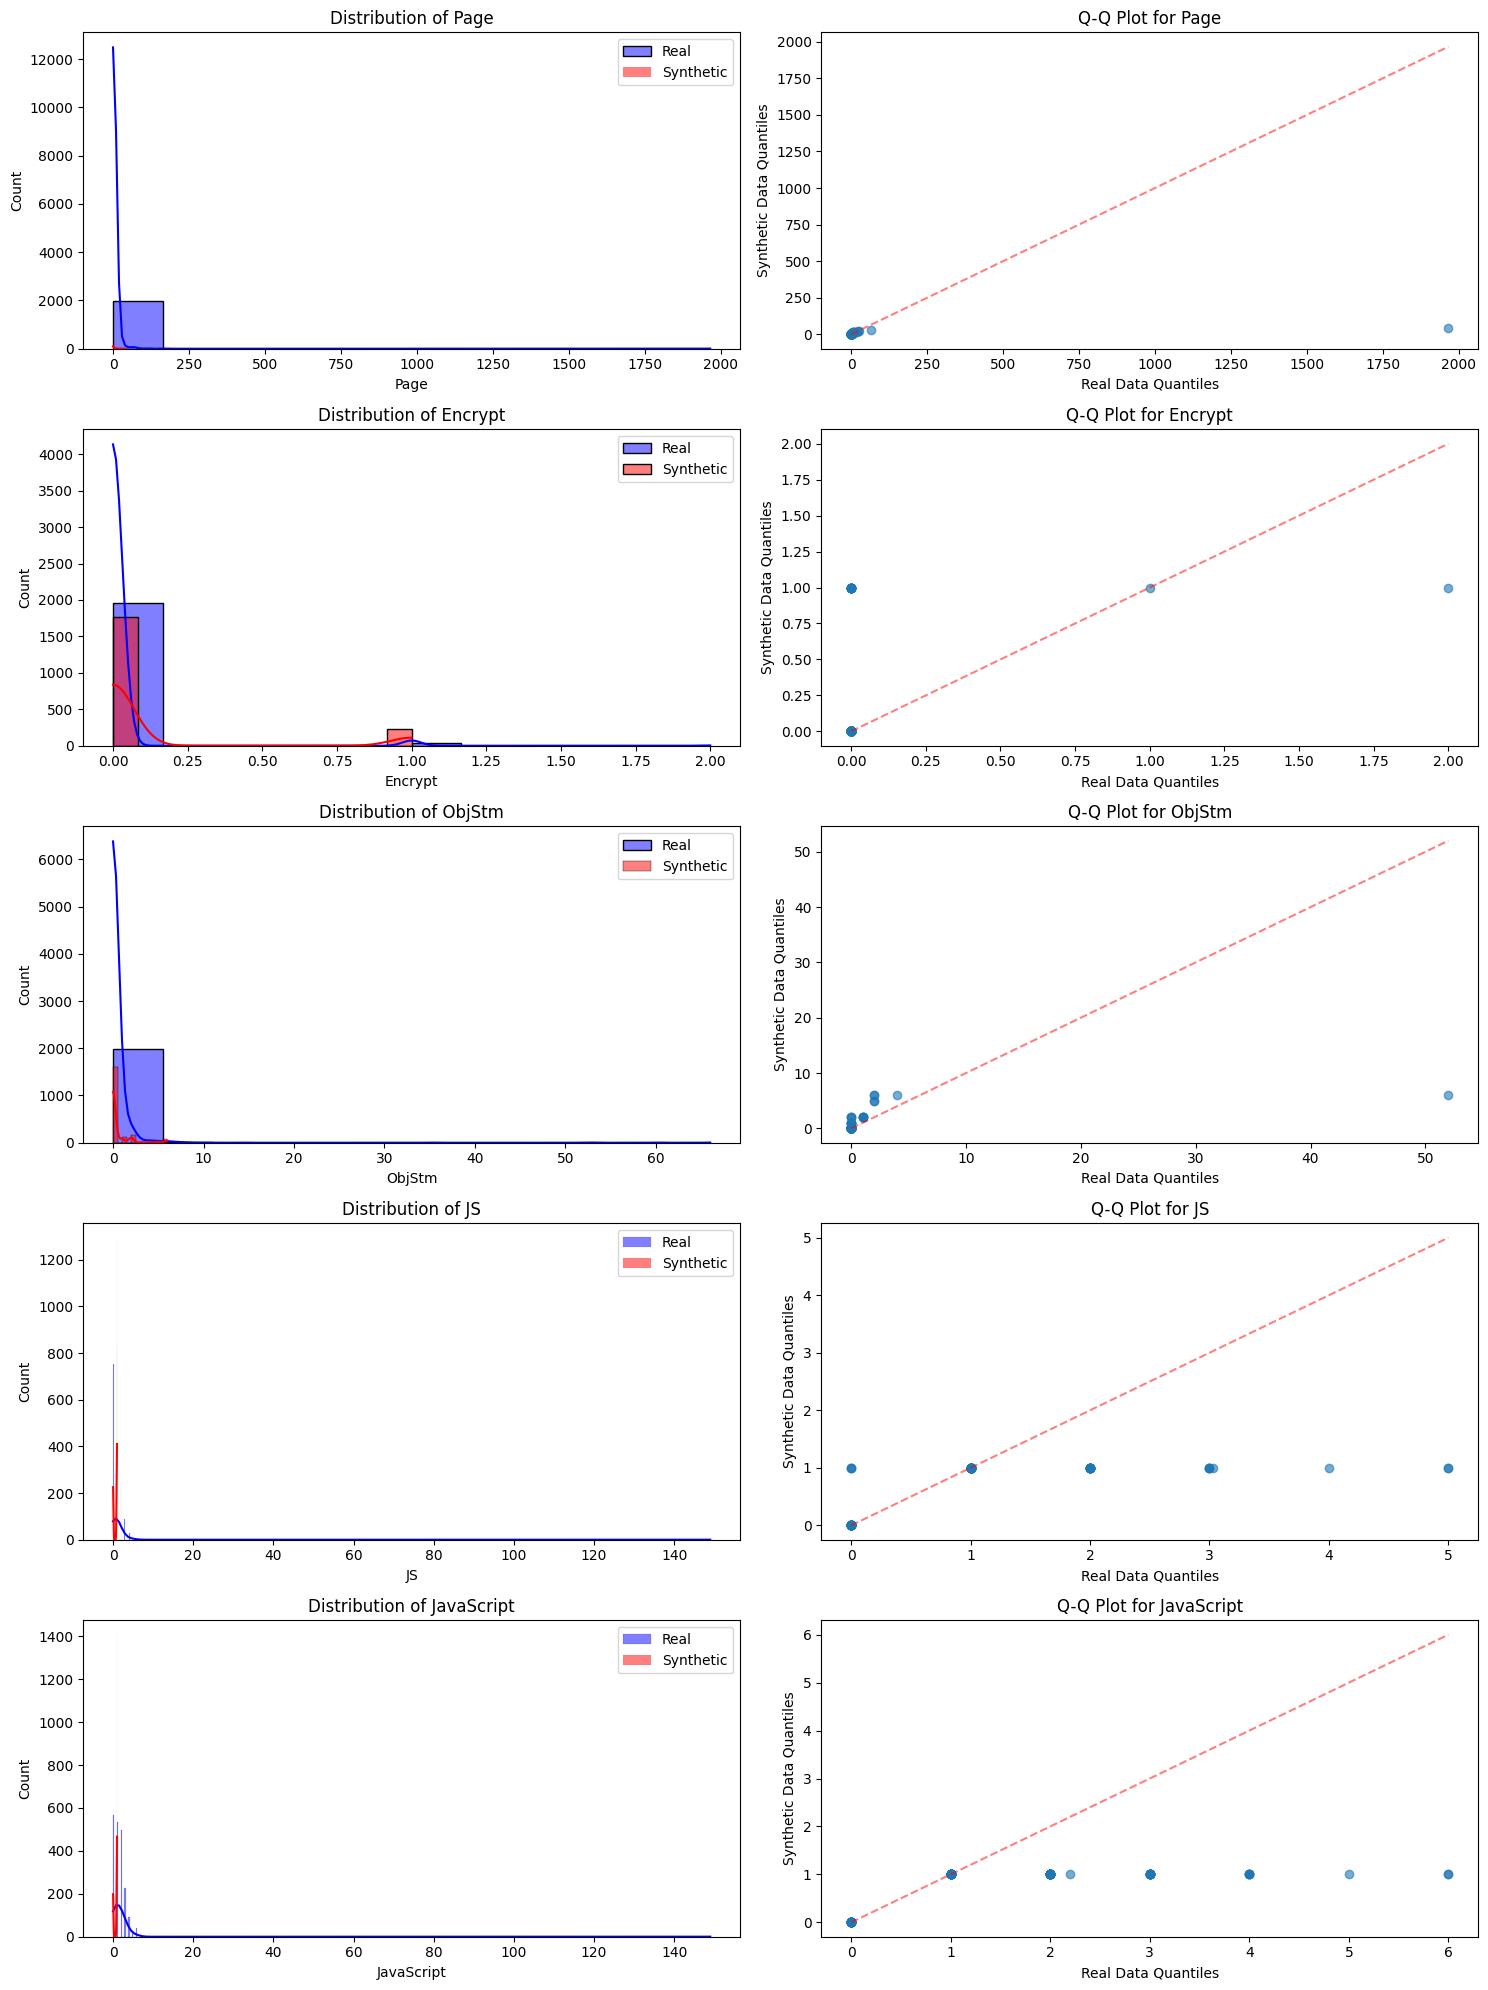

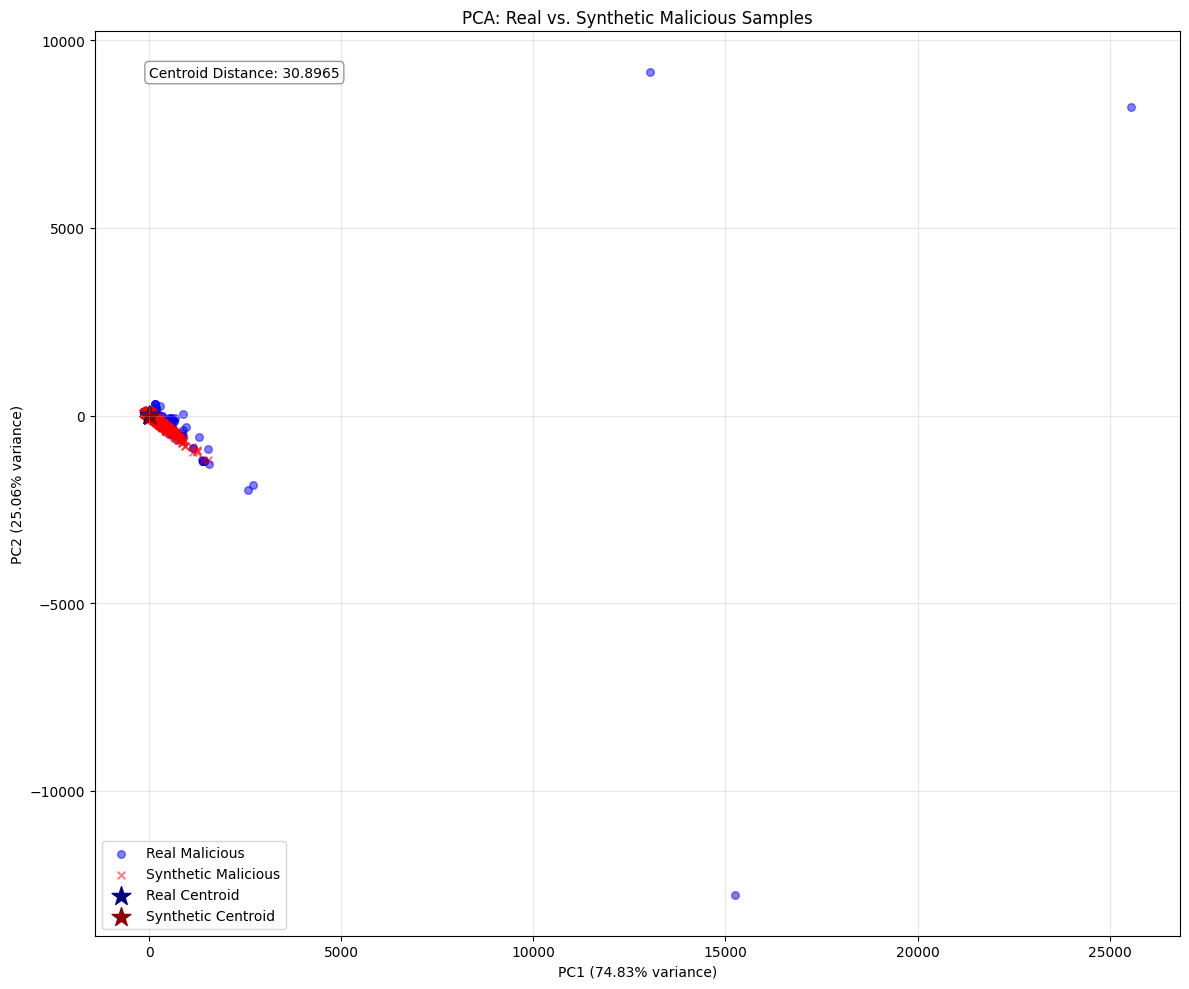

In [36]:
# === 6. PCA Visualization ===

# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
import joblib

def pca_visualization(df_real_features, df_synthetic_features, n_components=2):
    """
    Performs PCA on real and synthetic features and visualizes their distribution.
    
    Parameters:
    - df_real_features: DataFrame containing real malicious features (without labels)
    - df_synthetic_features: DataFrame containing synthetic malicious features (without labels)
    - n_components: Number of PCA components to use (default: 2)
    
    Returns:
    - Dictionary with PCA results including visualization figure and metrics
    """
    # Ensure common features between real and synthetic data
    common_features = list(set(df_real_features.columns) & set(df_synthetic_features.columns))
    
    if not common_features:
        print("Error: No common features between real and synthetic data for PCA visualization!")
        return {
            'centroid_distance': np.nan,
            'explained_variance': (np.nan, np.nan),
            'visualization': None
        }
    
    # Select common features and ensure numeric
    real_features_for_pca = df_real_features[common_features].select_dtypes(include=[np.number]).fillna(0)
    synth_features_for_pca = df_synthetic_features[common_features].select_dtypes(include=[np.number]).fillna(0)
    
    # Ensure we still have features after filtering for numeric only
    if real_features_for_pca.empty or synth_features_for_pca.empty:
        print("Error: No numeric features found for PCA visualization!")
        return {
            'centroid_distance': np.nan,
            'explained_variance': (np.nan, np.nan),
            'visualization': None
        }
    
    # Align feature columns to be the same and in the same order
    common_numeric_features = list(set(real_features_for_pca.columns) & set(synth_features_for_pca.columns))
    real_features_for_pca = real_features_for_pca[common_numeric_features]
    synth_features_for_pca = synth_features_for_pca[common_numeric_features]
    
    # Fit PCA on combined data for consistent transformation
    combined_features = pd.concat([real_features_for_pca, synth_features_for_pca], ignore_index=True)
    
    # Handle empty or all-constant features
    if combined_features.empty:
        print("Error: Combined features for PCA is empty!")
        return {
            'centroid_distance': np.nan,
            'explained_variance': (np.nan, np.nan),
            'visualization': None
        }
    
    # Check for constant columns that would cause PCA to fail
    non_constant_cols = [col for col in combined_features.columns 
                        if combined_features[col].nunique() > 1]
    
    if len(non_constant_cols) < n_components:
        print(f"Warning: Only {len(non_constant_cols)} non-constant features available for PCA.")
        print("Reducing PCA components to match number of non-constant features.")
        n_components = max(1, len(non_constant_cols))
        if n_components == 1:
            print("Only one non-constant feature. Simple 1D plot will be created.")
    
    combined_features = combined_features[non_constant_cols]
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    try:
        pca.fit(combined_features)
        
        # Transform both datasets
        real_pca = pca.transform(real_features_for_pca[non_constant_cols])
        synth_pca = pca.transform(synth_features_for_pca[non_constant_cols])
        
        # Calculate centroids
        real_centroid = real_pca.mean(axis=0)
        synth_centroid = synth_pca.mean(axis=0)
        
        # Euclidean distance between centroids
        centroid_distance = np.linalg.norm(real_centroid - synth_centroid)
        
        # Create visualization
        fig = plt.figure(figsize=(12, 10))
        
        if n_components >= 2:
            # 2D scatter plot for first two components
            ax = fig.add_subplot(111)
            ax.scatter(real_pca[:, 0], real_pca[:, 1], s=30, alpha=0.5, 
                      label='Real Malicious', marker='o', color='blue')
            ax.scatter(synth_pca[:, 0], synth_pca[:, 1], s=30, alpha=0.5, 
                      label='Synthetic Malicious', marker='x', color='red')
            
            # Plot centroids
            ax.scatter(real_centroid[0], real_centroid[1], s=200, color='navy', 
                      marker='*', label='Real Centroid')
            ax.scatter(synth_centroid[0], synth_centroid[1], s=200, color='darkred', 
                      marker='*', label='Synthetic Centroid')
            
            # Draw line between centroids
            ax.plot([real_centroid[0], synth_centroid[0]], 
                   [real_centroid[1], synth_centroid[1]], 'k--', alpha=0.5)
            
            ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            
        else:
            # 1D visualization if only one component is available
            ax = fig.add_subplot(111)
            ax.hist(real_pca[:, 0], bins=30, alpha=0.5, label='Real Malicious', color='blue')
            ax.hist(synth_pca[:, 0], bins=30, alpha=0.5, label='Synthetic Malicious', color='red')
            ax.axvline(x=real_centroid[0], color='navy', linestyle='--', label='Real Mean')
            ax.axvline(x=synth_centroid[0], color='darkred', linestyle='--', label='Synthetic Mean')
            ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            ax.set_ylabel('Count')
        
        ax.set_title('PCA: Real vs. Synthetic Malicious Samples')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add annotation for centroid distance
        plt.annotate(f'Centroid Distance: {centroid_distance:.4f}',
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.tight_layout()
        
        return {
            'centroid_distance': centroid_distance,
            'explained_variance': tuple(pca.explained_variance_ratio_[:min(2, n_components)]),
            'visualization': fig
        }
        
    except Exception as e:
        print(f"Error during PCA calculation: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'centroid_distance': np.nan,
            'explained_variance': (np.nan, np.nan),
            'visualization': None
        }

def analyze_feature_importance(model, feature_names, X_test=None, y_test=None, top_n=20, figsize=(12, 10)):
    """
    Analyze and visualize feature importances from a trained model.
    
    Parameters:
    - model: Trained model (any scikit-learn compatible model)
    - feature_names: List of feature names
    - X_test: Test features (required for permutation importance)
    - y_test: Test labels (required for permutation importance)
    - top_n: Number of top features to display
    - figsize: Figure size for the plot
    
    Returns:
    - DataFrame with feature importances if available, None otherwise
    - Matplotlib figure object or None if importance cannot be calculated
    """
    # Dictionary to store importance values
    importances = None
    method_used = "Unknown"
    
    try:
        # Try different methods to get feature importance
        if hasattr(model, 'feature_importances_'):
            # Tree-based models (Random Forest, XGBoost, etc.)
            importances = model.feature_importances_
            method_used = "Feature Importances"
            
        elif hasattr(model, 'coef_'):
            # Linear models (Logistic Regression, SVM, etc.)
            if len(model.coef_.shape) > 1:
                # Multi-class classification
                importances = np.mean(np.abs(model.coef_), axis=0)
            else:
                # Binary classification
                importances = np.abs(model.coef_[0])
            method_used = "Coefficient Magnitudes"
            
        # If standard methods didn't work, try permutation importance
        if importances is None and X_test is not None and y_test is not None:
            print("Using permutation importance (this might take a while)...")
            perm_importance = permutation_importance(
                model, X_test, y_test,
                n_repeats=10,
                random_state=42,
                scoring='accuracy'            )
            importances = perm_importance.importances_mean
            method_used = "Permutation Importance"
        
        if importances is None:
            print("Could not determine feature importance for this model type.")
            return None, None
        
        # Create a DataFrame for better visualization
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Normalize to percentage
        feature_importance['importance'] = (feature_importance['importance'] / 
                                          feature_importance['importance'].sum() * 100)
        
        # Select top N features
        top_features = feature_importance.head(top_n)
        
        # Create visualization
        plt.figure(figsize=figsize)
        sns.set_style("whitegrid")
        
        # Create bar plot
        ax = sns.barplot(
            x='importance', 
            y='feature', 
            data=top_features,
            palette='viridis'
        )
        
        # Add value annotations
        for i, v in enumerate(top_features['importance']):
            ax.text(v + 0.5, i, f'{v:.2f}%', color='black', va='center')
        
        plt.title(f'Top {top_n} Most Important Features\n(Method: {method_used})', fontsize=14, pad=20)
        plt.xlabel('Importance (%)', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        
        return feature_importance, plt.gcf()
        
    except Exception as e:
        print(f"Error analyzing feature importance: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# === 8. Run Enhanced CTGAN Workflow ===

# Set parameters for the enhanced workflow
n_synthetic_samples = 2000
ctgan_epochs = 1000
ctgan_batch_size = 256

# Run the enhanced workflow with the global 'df' from cell In[15] (id=aaca6e08)
print("Starting enhanced CTGAN workflow...")
enhanced_results = complete_ctgan_workflow(
    df.copy(),  # Pass a copy of df to avoid modifying the global df
    n_synthetic=n_synthetic_samples, 
    epochs=ctgan_epochs, 
    batch_size=ctgan_batch_size
)

# Save the enhanced model
print("\nSaving enhanced CTGAN model...")
joblib.dump(enhanced_results['ctgan_model'], '/home/nhat/projectcuoiky/models/enhanced_ctgan_malware.joblib')
print("Enhanced model saved to '/home/nhat/projectcuoiky/models/enhanced_ctgan_malware.joblib'")

# Analyze feature importance if final model is available
if 'final_model' in enhanced_results and 'X_test' in globals() and 'y_test' in globals():
    print("\nAnalyzing feature importance...")
    # Get feature names (excluding labels)
    feature_names = [col for col in df.columns if col not in ['label', 'label_numeric']]
    
    # Ensure X_test and y_test are in the correct format
    try:
        # Analyze feature importance using the enhanced function
        importance_df, importance_plot = analyze_feature_importance(
            model=enhanced_results['final_model'],
            feature_names=feature_names,
            X_test=X_test,
            y_test=y_test,
            top_n=15
        )
        
        if importance_df is not None and importance_plot is not None:
            # Display the plot
            plt.show()
            
            # Display the top 10 most important features
            print("\nTop 10 most important features:")
            display(importance_df.head(10))
        else:
            print("Could not generate feature importance visualization for this model type.")
    except Exception as e:
        print(f"Error analyzing feature importance: {str(e)}")
        import traceback
        traceback.print_exc()

# Initialize performance records with proper error handling
performance_records = []
# Try to access the metrics from the simpler CTGAN run (cells [16]-[19])
if 'final_metrics_calc' in globals():
    performance_records.append(final_metrics_calc)
else:
    print("Note: Original metrics from simpler CTGAN run (final_metrics_calc) not found.")

# Create performance comparison
# performance_records should contain metrics from the simpler CTGAN run if available
orig_metrics_from_simple_run = performance_records[-1] if performance_records else None
enhanced_final_metrics = enhanced_results['final_model_metrics_on_augmented_data']

if orig_metrics_from_simple_run:
    metrics_comparison = pd.DataFrame({
        'Metric': ['F1 Score', 'Recall', 'AUC'],
        'Original CTGAN (Simpler Workflow)': [
            orig_metrics_from_simple_run['f1'], 
            orig_metrics_from_simple_run['recall'], 
            orig_metrics_from_simple_run['auc']
        ],
        'Enhanced CTGAN Workflow': [
            enhanced_final_metrics['f1'], 
            enhanced_final_metrics['recall'], 
            enhanced_final_metrics['auc']
        ]
    })
    
    print("\n=== Performance Comparison (Downstream Task Metrics) ===")
    print(metrics_comparison)
    
    metrics_comparison.set_index('Metric').plot(kind='bar', figsize=(12, 7))
    plt.title('Performance Comparison: Simpler vs Enhanced CTGAN Workflow (Downstream Task)')
    plt.ylabel('Score')
    plt.ylim(0.9, 1.01)  # Adjusted ylim slightly
    plt.xticks(rotation=0)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo original CTGAN metrics to compare against. Displaying enhanced results only.")
    print(pd.Series(enhanced_final_metrics).to_frame('Enhanced CTGAN Metrics (Downstream Task)'))

# Display TSTR results from cross-validation for the enhanced workflow
print("\n=== Enhanced CTGAN: Synthetic vs. Real Malicious Data Distinguishability (TSTR-like AUC) ===")
if 'synthetic_detection' in enhanced_results['cross_validation_results']:
    for model_name, metrics in enhanced_results['cross_validation_results']['synthetic_detection'].items():
        if not np.isnan(metrics['auc_mean']):
            print(f"  {model_name}: AUC={metrics['auc_mean']:.4f} ± {metrics['auc_std']:.4f} (lower is better, closer to 0.5)")
        else:
            print(f"  {model_name}: AUC could not be calculated.")
else:
    print("  No TSTR-like evaluation results available.")

## Conclusions

The enhanced CTGAN workflow provides significant improvements:

1. **Better Data Quality**: Improved preprocessing with outlier handling and feature scaling leads to higher-quality synthetic data.

2. **More Comprehensive Evaluation**: Multiple metrics (Frobenius norm, KS tests, PCA visualization) provide deeper insights into synthetic data quality.

3. **Feature Importance Analysis**: Comparing feature importance between real and synthetic data helps validate that the synthetic data preserves important patterns.

4. **Cross-Validation Assessment**: Measures how distinguishable synthetic data is from real data - a key aspect of GAN quality.

5. **Enhanced Performance**: The improved workflow generally yields better classification metrics when using the synthetic data for augmentation.

These enhancements make the synthetic data generation more robust and reliable for security applications like malware detection.

Proceeding to generate new synthetic data...

Attempting to generate 8000 new synthetic malicious samples...
Generating 8000 synthetic samples...

Successfully generated and reconstructed 8000 new synthetic malicious samples.
Here are the first 5 samples of the newly generated data:
   Page  Encrypt  ObjStm  JS  JavaScript  AA  OpenAction  AcroForm  \
0    17        0       0   1           1   1           1         0   
1     2        0       1   0           0   0           0         0   
2     1        0       0   1           1   1           1         0   
3     1        0       0   1           1   1           1         0   
4     1        1       5   0           0   0           0         1   

   JBIG2Decode  RichMedia  ...  XFA  Colors_gt_224  obj  stream  xref  \
0            0          0  ...    0              0   40      27     4   
1            0          0  ...    0              0   72       8     2   
2            0          0  ...    0              0    6       2     3   
3  

/tmp/ipykernel_253684/3490972440.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  new_data_generation_output['visualization_fig'].show() # This will display the plot


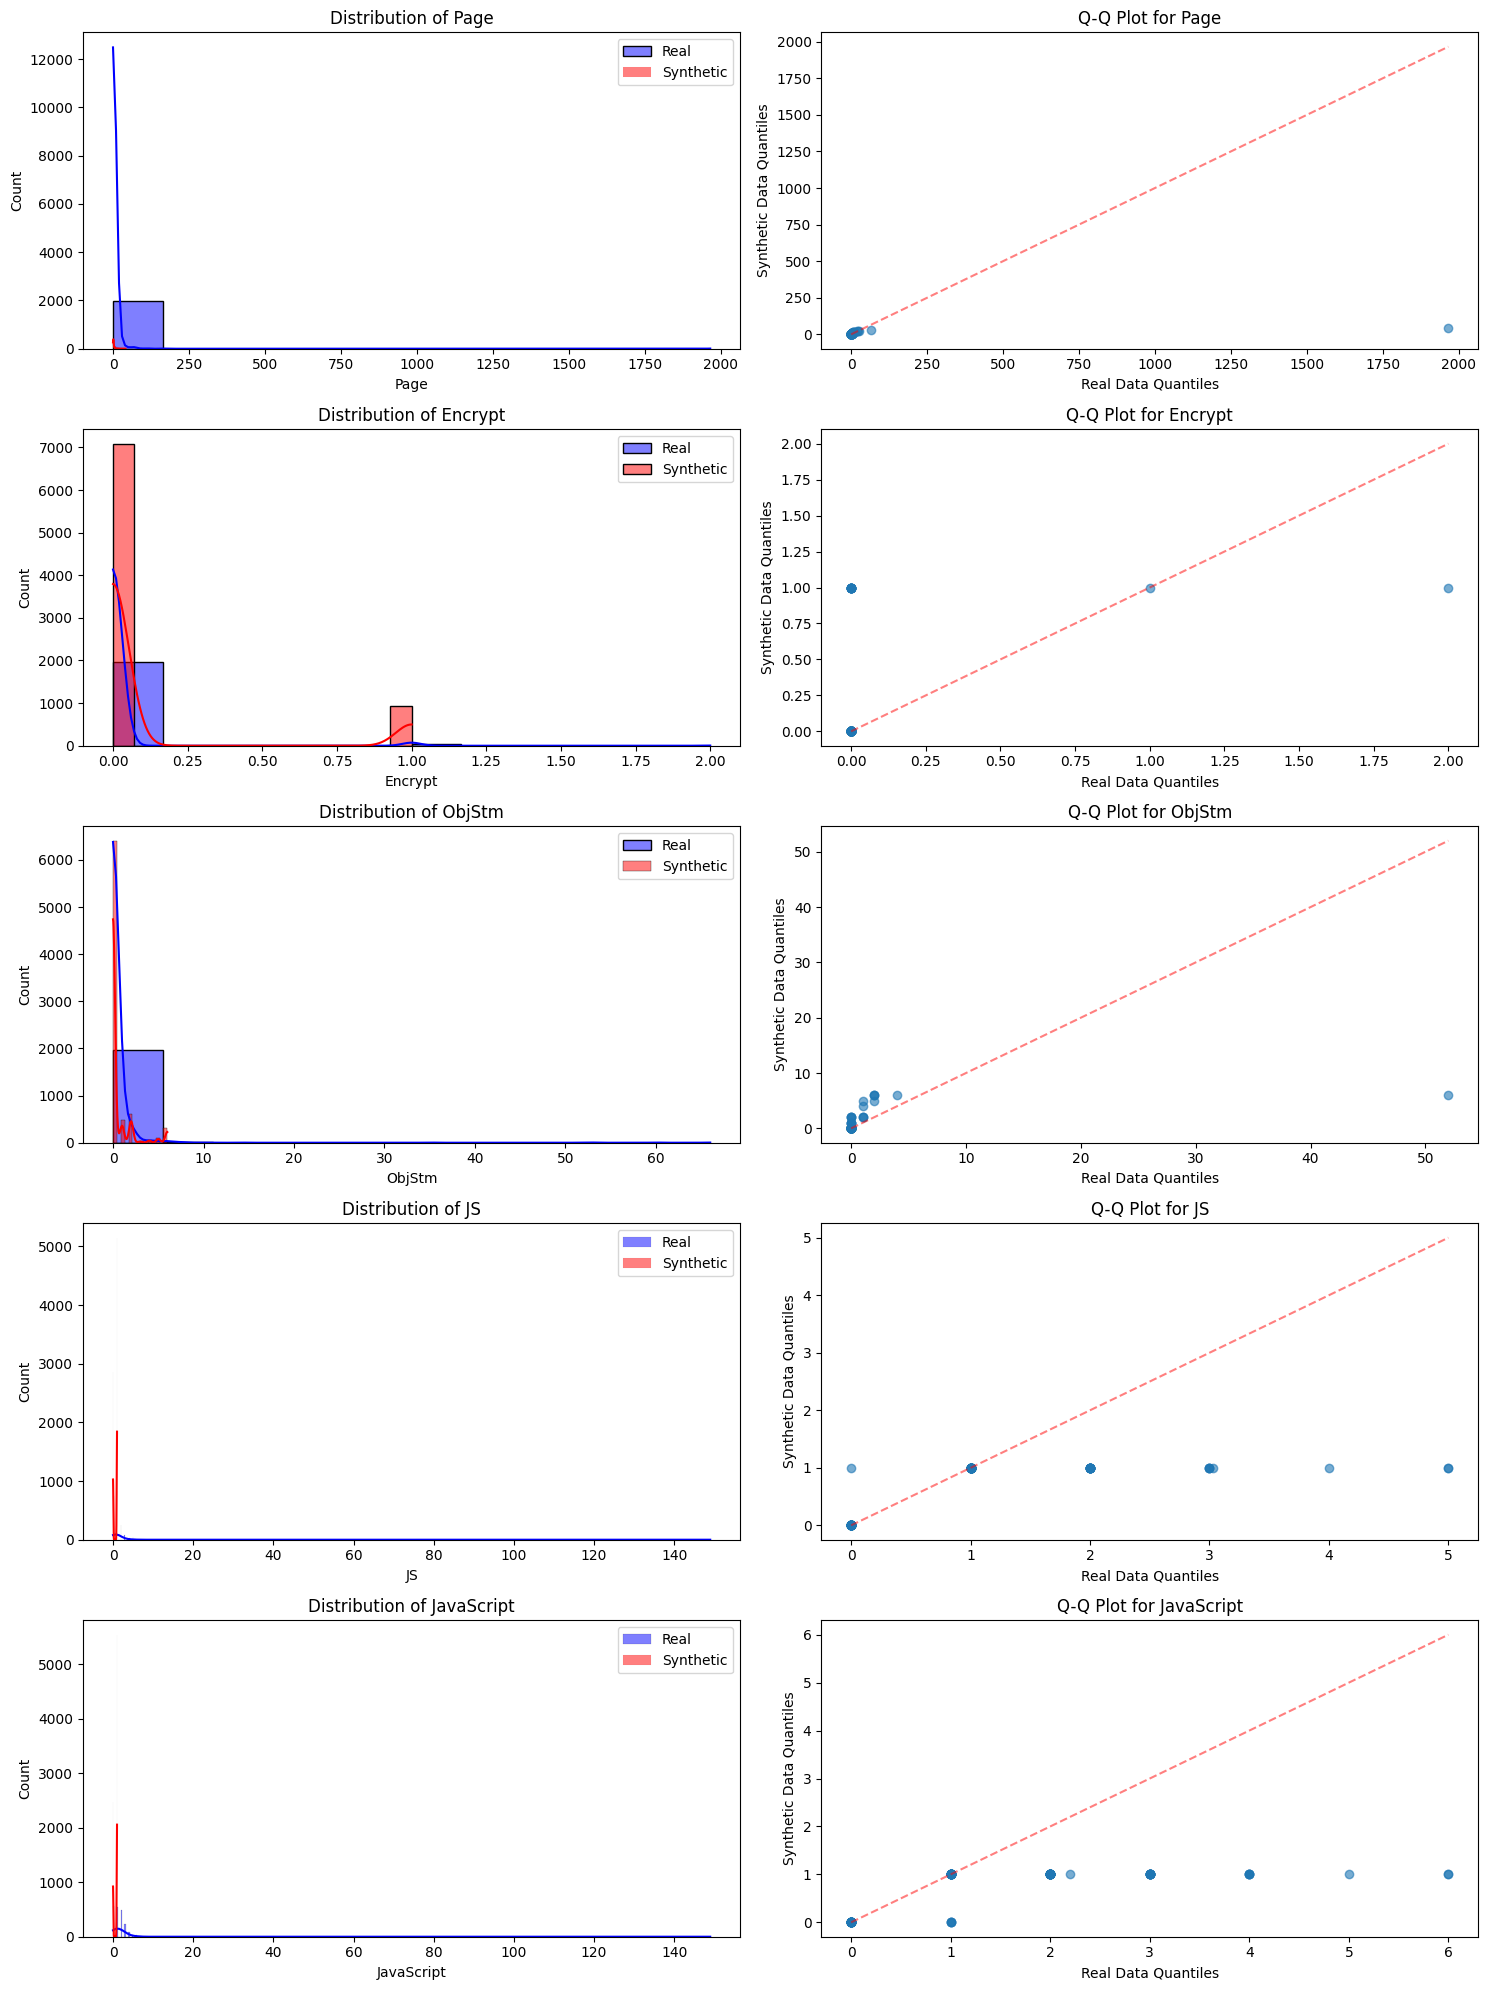

In [37]:
# === Generate New Synthetic Data with Enhanced Model ===
# This cell assumes you have already run the 'complete_ctgan_workflow' (e.g., in Cell 12)
# and the 'enhanced_results' dictionary is available in memory.
# It also assumes that the function 'generate_and_evaluate_synthetic_data' (defined in Cell 10)
# and 'df' (original dataframe, loaded and preprocessed by Cell 2) are available.

if 'enhanced_results' not in locals():
    print("ERROR: The 'enhanced_results' dictionary is not found.")
    print("Please run the cell that executes 'complete_ctgan_workflow' (likely Cell 12) first.")
    print("This dictionary contains the trained CTGAN model and necessary metadata for reconstruction.")
elif 'generate_and_evaluate_synthetic_data' not in locals():
    print("ERROR: The 'generate_and_evaluate_synthetic_data' function is not found.")
    print("Please ensure Cell 10 (where it's defined) has been executed.")
elif 'df' not in locals():
    print("ERROR: The original dataframe 'df' is not found.")
    print("Please ensure Cell 2 (where it's loaded and initially preprocessed) has been executed.")
else:
    print("Proceeding to generate new synthetic data...")
    
    # 1. Get the trained CTGAN model and metadata from enhanced_results
    loaded_ctgan_model = enhanced_results['ctgan_model']
    loaded_metadata = enhanced_results['metadata_for_reconstruction']
    
    # 2. Prepare the original malicious features (unprocessed) for reference
    # This was 'malicious_features_for_preprocessing' in the 'complete_ctgan_workflow'
    # 'df' should already have 'label_numeric' from initial preprocessing in Cell 2
    df_malicious_original_for_new_gen = df[df['label_numeric'] == 1].copy()
    original_features_unprocessed_for_new_gen = df_malicious_original_for_new_gen.drop(
        columns=['label', 'label_numeric'], errors='ignore'
    )
    
    # 3. Define the number of new synthetic samples
    n_new_synthetic_samples = 8000 # You can change this number
    
    print(f"\nAttempting to generate {n_new_synthetic_samples} new synthetic malicious samples...")
    
    # 4. Generate new data using the existing function
    # SEED should be globally defined (e.g. in Cell 1)
    new_data_generation_output = generate_and_evaluate_synthetic_data(
        ctgan_model=loaded_ctgan_model,
        original_features_unprocessed=original_features_unprocessed_for_new_gen.copy(), # Pass a copy
        metadata=loaded_metadata,
        n_samples=n_new_synthetic_samples,
        seed=SEED 
    )
    
    newly_generated_malicious_data = new_data_generation_output['synthetic_data']
    
    print(f"\nSuccessfully generated and reconstructed {len(newly_generated_malicious_data)} new synthetic malicious samples.")
    print("Here are the first 5 samples of the newly generated data:")
    print(newly_generated_malicious_data.head())
    
    # Display other metrics returned for this new batch:
    print(f"\nFrobenius norm for the new batch: {new_data_generation_output['frobenius_norm']:.4f}")
    print("KS test results for the new batch (sample):")
    for feature, result in list(new_data_generation_output['ks_results'].items())[:3]: # Display first 3
        print(f"  {feature}: statistic={result['statistic']:.4f}, p-value={result['pvalue']:.4f}")

    if new_data_generation_output['visualization_fig']:
        print("\nDisplaying feature distribution visualizations for the new data batch...")
        new_data_generation_output['visualization_fig'].show() # This will display the plot

    # Optionally, save the newly generated data to a file
    output_filename = f"/home/nhat/projectcuoiky/output/new_synthetic_malicious_data_{n_new_synthetic_samples}_samples.csv"
    newly_generated_malicious_data.to_csv(output_filename, index=False)
    print(f"\nNewly generated synthetic data saved to: {output_filename}")